In [699]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns 
import matplotlib.pyplot as plt


     x1    x2    x3    x4    x5
0  0.02  0.05 -0.09 -0.43 -0.08
1 -0.13  0.11 -0.08 -0.29 -0.03
2  0.08  0.06 -0.07 -0.41 -0.03
3  0.02 -0.12  0.01 -0.43 -0.02
4 -0.14 -0.12 -0.08 -0.02 -0.08
<class 'numpy.float64'>
lr: 0.2
________________________
l2: 0.001 epoch: 500
loss 1.9487855286605031
l2: 0.00526530612244898 epoch: 500
loss 1.9500727281431354
l2: 0.00953061224489796 epoch: 500
loss 1.9511503452665293
l2: 0.013795918367346938 epoch: 500
loss 1.9520266938296713
l2: 0.01806122448979592 epoch: 500
loss 1.9527396243423736
l2: 0.022326530612244898 epoch: 500
loss 1.9533283843177023
l2: 0.02659183673469388 epoch: 500
loss 1.9538256866808477
l2: 0.03085714285714286 epoch: 500
loss 1.9542567451257604
l2: 0.03512244897959184 epoch: 500
loss 1.9546403834414001
l2: 0.03938775510204082 epoch: 500
loss 1.9549904998680916
l2: 0.043653061224489795 epoch: 500
loss 1.9553173526692893
l2: 0.04791836734693878 epoch: 500
loss 1.9556285563707039
l2: 0.05218367346938776 epoch: 500
loss 1.955929814145

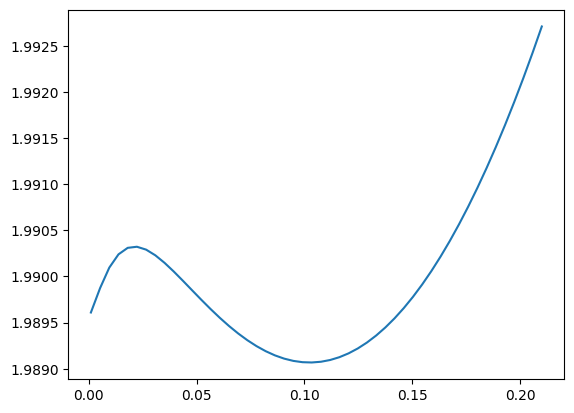

In [758]:

def transform_data(X):
    """
    This function transforms the 5 input features of matrix X (x_i denoting the i-th component of X) 
    into 21 new features phi(X) in the following manner:
    5 linear features: phi_1(X) = x_1, phi_2(X) = x_2, phi_3(X) = x_3, phi_4(X) = x_4, phi_5(X) = x_5
    5 quadratic features: phi_6(X) = x_1^2, phi_7(X) = x_2^2, phi_8(X) = x_3^2, phi_9(X) = x_4^2, phi_10(X) = x_5^2
    5 exponential features: phi_11(X) = exp(x_1), phi_12(X) = exp(x_2), phi_13(X) = exp(x_3), phi_14(X) = exp(x_4), phi_15(X) = exp(x_5)
    5 cosine features: phi_16(X) = cos(x_1), phi_17(X) = cos(x_2), phi_18(X) = cos(x_3), phi_19(X) = cos(x_4), phi_20(X) = cos(x_5)
    1 constant features: phi_21(X)=1

    Parameters
    ----------
    X: matrix of floats, dim = (700,5), inputs with 5 features

    Returns
    ----------
    X_transformed: array of floats: dim = (700,21), transformed input with 21 features
    """
    X_transformed = np.zeros((700, 21))
    # TODO: Enter your code here
    for i in range(5):
        X_transformed[:,i] = X[:,i]
        X_transformed[:, i+5] = np.square(X[:,i])
        X_transformed[:,i+10] = np.exp(X[:,i])
        X_transformed[:,i+15] = np.cos(X[:,i])
    X_transformed[:,20] = 1
    #sns.scatterplot(data=X_transformed)
    #plt.show()
    assert X_transformed.shape == (700, 21)
    return X_transformed


def validate(X_transformed, y, w):
    torch.manual_seed(42) 
    #print(f'malmul: {np.dot(X,w.T)}')
    X_validate = torch.from_numpy(X_transformed.astype(np.float64))
    y_validate = torch.from_numpy(y.reshape(y.shape[0],1).astype(np.float64))
    model_validate = torch.nn.Linear(21,1)
    model_validate.weight = torch.nn.Parameter(torch.from_numpy(w.reshape(1,21).astype(np.float64)))
    loss_func =  torch.nn.MSELoss()
    
    y_hat = model_validate.forward(X_validate)
    #print(f'yhat: {y_hat}')
    loss = torch.sqrt(loss_func(y_hat, y_validate))
    #print(f'Validation loss: {loss.item()}')
    return loss.item()

def fit(X, y, lr, momentum, epochs, l1,l2):
    """
    This function receives training data points, transform them, and then fits the linear regression on this 
    transformed data. Finally, it outputs the weights of the fitted linear regression. 

    Parameters
    ----------
    X: matrix of floats, dim = (700,5), inputs with 5 features
    y: array of floats, dim = (700,), input labels)

    Returns
    ----------
    w: array of floats: dim = (21,), optimal parameters of linear regression
    """
    X_train = torch.from_numpy(X.astype(np.float64))
    y_train = torch.from_numpy(y.reshape(y.shape[0],1).astype(np.float64))
    #model to be trained
    model = torch.nn.Linear(21,1, bias=False)
    #initialize weights as zero
    torch.nn.init.zeros_(model.weight)
    #initialize loss function
    loss_func = torch.nn.MSELoss()
    #initialize stochastic gradient descent
    optimization = torch.optim.SGD(model.parameters(), lr, momentum,weight_decay = l2)
    #train epochs times
    for epoch in range(epochs):
        y_hat = model(X_train)
        loss = torch.sqrt(loss_func(y_hat, y_train)) + l1*torch.norm(model.weight,1)
        loss.backward()
        optimization.step()
        optimization.zero_grad()
    #get weights
    w = model.weight.detach().numpy().reshape(21)
    print(f'loss {loss.item()}')
    #assert shape
    assert w.shape == (21,)
    return w


# Main function. You don't have to change this
if __name__ == "__main__":
    # Data loading
    torch.set_default_dtype(torch.float64)
    data = pd.read_csv("train.csv")
    y = data["y"].to_numpy()
    data = data.drop(columns=["Id", "y"])
    # print a few data samples
    print(data.head())
    #sns.scatterplot(data=data)
    #show the plot
    #plt.show()


    X = transform_data(data.to_numpy())

    print(type(X[1][1]))
    # Extract 100% of the data for training
    X_train = X[:700, :]
    y_train = y[:700]
    # Extract part of the data for validation
    X_val = X[100:200, :]
    y_val = y[100:200]
    #Dict, where the different performances get appended
    validation_performance = {}
    #hyperparameter tuning
    for lr in np.linspace(0.2, 0.2, 1):
        print(f'lr: {lr}', end="\n")
        print('________________________')
        for l2 in np.linspace(0.001, 0.21, 50):
            
            for epochs in [500]:
                print(f'l2: {l2} epoch: {epochs}')
                #fit the model
                w = fit(X_train, y_train, lr, 0.31, epochs, 0, l2)
                # Compute the validation loss 
                validation_sum = validate(X_val, y_val, w)
                validation_performance[l2] = validation_sum
        print('________________________', end="\n\n\n")
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(validation_performance.keys(), validation_performance.values(), color='tab:blue')
    # Save results in the required format
    plt.show()
    np.savetxt("./results.csv", w, fmt="%.12f")
